<a href="https://colab.research.google.com/github/kylemath/DeepEEG/blob/master/notebooks/DeepEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepEEG


In [1]:
!git clone https://github.com/kylemath/DeepEEG
!chmod +x ./DeepEEG/install.sh
!./DeepEEG/install.sh
from DeepEEG.tools import *
from DeepEEG.utils import *
%matplotlib inline


Cloning into 'DeepEEG'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 477 (delta 85), reused 69 (delta 30), pack-reused 316
Receiving objects: 100% (477/477), 17.59 MiB | 24.18 MiB/s, done.
Resolving deltas: 100% (215/215), done.
    100% |████████████████████████████████| 6.2MB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


Using TensorFlow backend.


#Connect to Google Drive

In [2]:
#mount google drive to load own images, follow link and get code and paste in below
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Run Brain Recorder Loading Data

*  Each data file is from a condition in an EEG experiment, from folder in google drive


In [3]:
#Data Settings#
path = 'gdrive/My Drive/data/'
exp = 'bikepark'
conditions = ['quiet','traffic']
subs = ['005', '007', '009', '010', '012', '013', '014', '015', '016', '019']
#subs = [ '015']

event_names = ['Standard','Target']
event_nums = [1,2] # 1 Standard, 2 Target, 9 Response

#exp = 'P2_Soundz'
#conditions = ['']
#subs = ['001', '003', '004', '005', '006', '007', '009', '010', '011', '012', '013', '015', '016', '017'];#P2_Sounds
#subs = ['006']
#event_names = ['Standard/Silent','Standard/Sound','Standard/White','Standard/Silent_Low',
#               'Target/Silent','Target/Sound','Target/White','Target/Silent_Low']
#event_nums = [1,8,5,7,2,3,6,9]


for isub,sub in enumerate(subs):       
  print('Loading data for subject number: ' + sub)
  
  
  for icond, condition in enumerate(conditions):
    
    if len(conditions) > 1:
      fname = path + exp + '/' + sub + '_' + exp + '_' + condition + '.vhdr'
    else:
      fname = path + exp + '/' + sub + '_' + exp + '.vhdr'
      
    tempraw,sfreq = load_data(fname,data_type='recorder',plot_sensors=False,plot_raw=False,plot_raw_psd=False,stim_channel=True)
    if icond==0 and isub==0:
      raw = tempraw
    else:
      raw.append(tempraw)

Loading data for subject number: 005
Extracting parameters from gdrive/My Drive/data/bikepark/005_bikepark_quiet.vhdr...
Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 952379  =      0.000 ...  1904.758 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/005_bikepark_traffic.vhdr...
Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 980079  =      0.000 ...  1960.158 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 007
Extracting parameters from gdrive/My Drive/data/bikepark/007_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 771 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 982359  =      0.000 ...  1964.718 secs...
Used Annotations descriptions: ['Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/007_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1199 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 879709  =      0.000 ...  1759.418 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 009
Extracting parameters from gdrive/My Drive/data/bikepark/009_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1206 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1372879  =      0.000 ...  2745.758 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/009_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1208 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 853929  =      0.000 ...  1707.858 secs...
Used Annotations descriptions: ['Stimulus/S 13', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 010
Extracting parameters from gdrive/My Drive/data/bikepark/010_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1208 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 971479  =      0.000 ...  1942.958 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/010_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1209 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1214799  =      0.000 ...  2429.598 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 012
Extracting parameters from gdrive/My Drive/data/bikepark/012_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1205 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 863459  =      0.000 ...  1726.918 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/012_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1210 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1577229  =      0.000 ...  3154.458 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 013
Extracting parameters from gdrive/My Drive/data/bikepark/013_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1806 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1308179  =      0.000 ...  2616.358 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/013_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1204 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1015009  =      0.000 ...  2030.018 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 014
Extracting parameters from gdrive/My Drive/data/bikepark/014_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1207 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1219869  =      0.000 ...  2439.738 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/014_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1195 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1391329  =      0.000 ...  2782.658 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 015
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1201 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1262439  =      0.000 ...  2524.878 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1209 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 940909  =      0.000 ...  1881.818 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 016
Extracting parameters from gdrive/My Drive/data/bikepark/016_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1211 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 936189  =      0.000 ...  1872.378 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/016_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1209 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1292389  =      0.000 ...  2584.778 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Loading data for subject number: 019
Extracting parameters from gdrive/My Drive/data/bikepark/019_bikepark_quiet.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1214 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 926969  =      0.000 ...  1853.938 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/019_bikepark_traffic.vhdr...


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1208 annotation(s) that were outside data range.
  raw.append(tempraw)


Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 973459  =      0.000 ...  1946.918 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations


<ipython-input-3-d29c4318f68c>:34: RuntimeWarning: Omitted 1228 annotation(s) that were outside data range.
  raw.append(tempraw)


#Load Muse Data from eeg-notebooks

In [2]:
print('Muse data load')
!git clone https://github.com/kylemath/eeg-notebooks/

#Parameters#
#subject folders in data folder
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

data_dir = 'visual/cueing'
event_names = ['LeftCue','RightCue']
nsesh = 2
load_verbose = True


#for testing
#subs = [ 205, 207, 208, 209]
subs = [2]
nsesh = 1
#number of sessions in each subject folder

## Can load other experiments like this - NN and CNN model works great
#subs = [ 1]
#nsesh = 1
#data_dir = 'visual/P300'
#event_names = ['Standard','Target']
##

## Can load other experiments like this - NN and CNN model works best here
#subs = [ 4]
#nsesh = 1
#data_dir = 'visual/SSVEP'
#event_names = ['f30Hz','f20Hz']

##

sfreq = 256.
event_nums = [1,2]

#Load Data
print('Loading Data')
isub = subs[0]
raw = muse_load_data(data_dir, sfreq=sfreq ,subject_nb=isub, session_nb=1,verbose=load_verbose)
if nsesh == 2:
  raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))

if len(subs)>1:
  for isub in subs[1:]:
    print(isub)
    raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=1,verbose=load_verbose))
    if nsesh == 2:
      raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))
  



  
  

Muse data load
Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1792 (delta 7), reused 0 (delta 0), pack-reused 1776
Receiving objects: 100% (1792/1792), 110.45 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (785/785), done.
Checking out files: 100% (487/487), done.
Loading Data
Creating RawArray with float64 data, n_channels=5, n_times=51060
    Range : 0 ... 51059 =      0.000 ...   199.449 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=51048
    Range : 0 ... 51047 =      0.000 ...   199.402 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=51048
    Range : 0 ... 51047 =      0.000 ...   199.402 secs
Ready.


#Run Preprocessing

Filtering Data
24733 events found
Event IDs: [  1   2   3   4   5   6   7   9  10  11  13  15 255]
('sample drop %: ', 100)


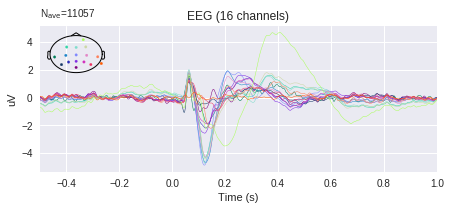

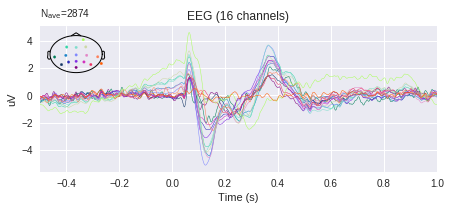

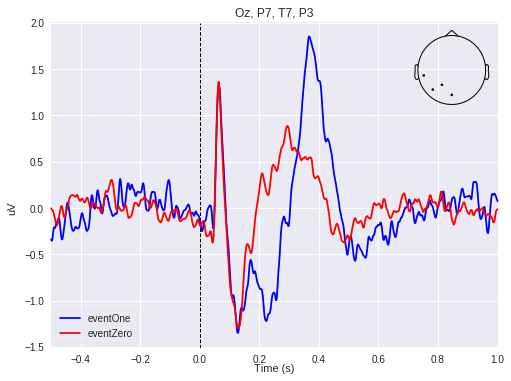

In [5]:
##Preprocessing Settings
event_id = {event_names[1]: event_nums[1], event_names[0]: event_nums[0]} #create dict

epochs = PreProcess(raw, event_id, rej_thresh_uV=200,
                    plot_psd=False,plot_events=False,plot_erp=True,
                   epoch_time=(-.5,1), baseline=(-.5,0))
                    

#plot_psd=False, filter_data=True, 
#eeg_filter_highpass=1, plot_events=False, , 
# rej_thresh_uV=150,
#epoch_decim=1, plot_electrodes=True,
#plot_erp=True

#keep epoch_decim=1 if using frequency_domain


#Run FeatureEngineer

In [6]:
#change this so epochs can either be a mne epochs object, 
#or can be an encoded latent space from the autoencoder
#automatically detects type
feats = FeatureEngineer( epochs, model_type = 'CNN3D',
                          frequency_domain=1,wave_cycles=3,flims=(4,20),f_bins=10,
                          spect_baseline=[-1,-.5],wavelet_decim=5,
                         electrodes_out=[7,8,9,10,11,12,13,14,15]
                       )
                             
#frequency_domain=0, 
#normalization=True,
#electrode_median=False,                                                                                                                     
#wavelet_decim=1,flims=(2,30),
#f_bins=20,wave_cycles=3,
#spect_baseline=[-1,-.5],
#electrodes_out= [13,14,15],
##electrodes_out= ,
#random_seed=1017

Constructing Frequency Domain Features
Computing Morlet Wavelets on Standard
Applying baseline correction (mode: mean)
Computing Morlet Wavelets on Target
Applying baseline correction (mode: mean)
Condition one trials: 2874
Target Time Points: 100
Target Frequencies: 10
Condition zero trials: 11057
Standard Time Points: 100
Standard Frequencies: 10
Normalizing X
Combined X Shape: (13931, 100, 10, 9, 1)
Combined Y Shape: (13931,)
Y Example (should be 1s & 0s): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X Range: -30.137987:59.25585
Input Shape: (100, 10, 9, 1)
('x_train shape:', (8358, 100, 10, 9, 1))
(8358, 'train samples')
(2787, 'test samples')
(2786, 'validation samples')
Class Weights: [0.63231956 2.38936535]


# Run CreateModel

In [7]:
print('Input shape: ' + str(feats.input_shape))
model, encoder, model_type = CreateModel(feats, model_type='CNN3D',units=[16,16],
                                       dropout=.25,batch_norm=False,filt_size=(6,2,2),pool_size=(6,2,2)) #longer in time dimension


Input shape: (100, 10, 9, 1)
Creating CNN3D Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 100, 10, 9, 16)    400       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 10, 9, 16)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 5, 5, 16)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                108816    
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)           

# TrainTestVal

Training Model:
Train on 8358 samples, validate on 2786 samples
Epoch 1/20
8358/8358 [==============================] - 3s 371us/step - loss: 0.5005 - acc: 0.7907 - val_loss: 0.4983 - val_acc: 0.7933
Epoch 2/20
8358/8358 [==============================] - 3s 326us/step - loss: 0.4995 - acc: 0.7907 - val_loss: 0.4976 - val_acc: 0.7933
Epoch 3/20
8358/8358 [==============================] - 3s 325us/step - loss: 0.4989 - acc: 0.7907 - val_loss: 0.4970 - val_acc: 0.7933
Epoch 4/20
8358/8358 [==============================] - 3s 325us/step - loss: 0.4984 - acc: 0.7907 - val_loss: 0.4967 - val_acc: 0.7933
Epoch 5/20
8358/8358 [==============================] - 3s 327us/step - loss: 0.4979 - acc: 0.7907 - val_loss: 0.4963 - val_acc: 0.7933
Epoch 6/20
8358/8358 [==============================] - 3s 320us/step - loss: 0.4975 - acc: 0.7907 - val_loss: 0.4960 - val_acc: 0.7933
Epoch 7/20
8358/8358 [==============================] - 3s 315us/step - loss: 0.4971 - acc: 0.7907 - val_loss: 0.4956 - 

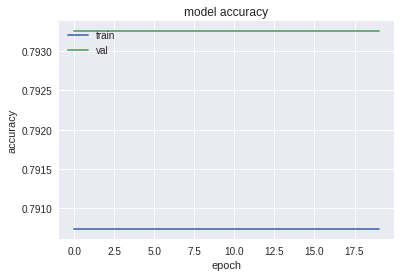

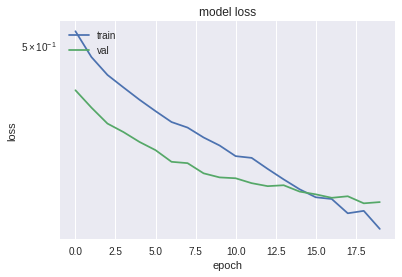

2787/2787 [==============================] - 0s 140us/step
['loss', 'acc']
('Test loss:', 0.4947988448666551)
('Test accuracy:', 0.8030139948246425)


In [9]:
TrainTestVal(model, feats,
             batch_size=256,train_epochs=20)

#Check the results of the autoencoder

In [0]:
x_all = np.append(feats.x_train,np.append(feats.x_val,feats.x_test,axis=0),axis=0)
y_all = np.append(feats.y_train,np.append(feats.y_val,feats.y_test,axis=0),axis=0)

#encoder input shape and decoder output shape are wrong for the data in the AUTODeep
encoded_data = encoder.predict(x_all)
decoded_data = model.predict(x_all)

print('x_all size: ' + str(x_all.shape))
print('y_all size: ' + str(y_all.shape))
print('encoded_data size: ' + str(encoded_data.shape))
print('decoded_data size: ' + str(decoded_data.shape))

nchans = len(pick_types(epochs.info, meg=False, eeg=True, eog=False))
ntimes = x_all.shape[1]/nchans
x_all = np.reshape(x_all,(x_all.shape[0],ntimes,nchans))
print('x_all size: ' + str(x_all.shape))
print('x_all size: ' + str(decoded_data.shape))

decoded_data = np.reshape(decoded_data,(decoded_data.shape[0],ntimes,nchans))
print(x_all.shape)

n = 10
chan = 0
#epochs.ch_names.index('Pz')
plt.figure(figsize=(10,10))
for i in range(n):
  for j in range(n):
    item_idx = (j*n)+i+1
    ax = plt.subplot(n,n,item_idx)
    plt.plot(x_all[item_idx,:,chan],'b')
    plt.plot(decoded_data[item_idx,:,chan],'r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()




print('x_all Shape: ' + str(x_all.shape))
print('y_all Shape: ' + str(y_all.shape))
chan = 0
#epochs.ch_names.index('Fz')

#divide into conditions
cond_zero_real = x_all[y_all[:,0]==0,:,chan]
cond_one_real = x_all[y_all[:,0]==1,:,chan]
cond_zero_decode = decoded_data[y_all[:,0]==0,:,chan]
cond_one_decode = decoded_data[y_all[:,0]==1,:,chan]

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
zero_err = np.std(cond_zero_real, axis=0)/10
one_err = np.std(cond_one_real, axis=0)/10
ax.fill_between(feats.new_times, np.mean(cond_zero_real, axis=0)-zero_err, np.mean(cond_zero_real, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(feats.new_times,np.mean(cond_zero_real, axis=0),'b',label=event_names[0])
ax.fill_between(feats.new_times, np.mean(cond_one_real, axis=0)-one_err, np.mean(cond_one_real, axis=0)+one_err,color=[1,.8,.8])
ax.plot(feats.new_times,np.mean(cond_one_real, axis=0),'r',label=event_names[1])
plt.title('Real')
ax.legend()

ax = plt.subplot(2,1,2)
zero_err = np.std(cond_zero_decode, axis=0)/10
one_err = np.std(cond_one_decode, axis=0)/10
ax.fill_between(feats.new_times, np.mean(cond_zero_decode, axis=0)-zero_err, np.mean(cond_zero_decode, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(feats.new_times,np.mean(cond_zero_decode, axis=0),'b',label=event_names[0])
ax.fill_between(feats.new_times, np.mean(cond_one_decode, axis=0)-one_err, np.mean(cond_one_decode, axis=0)+one_err,color=[1,.8,.8])
ax.plot(feats.new_times,np.mean(cond_one_decode, axis=0),'r',label=event_names[1])
plt.title('Autogenerated')
ax.legend()
plt.show()


AttributeError: ignored

#run the autoencoder embedded trials through a NN

Maybe the latent space could represent different components? 
frequency bands? 


Normalizing X


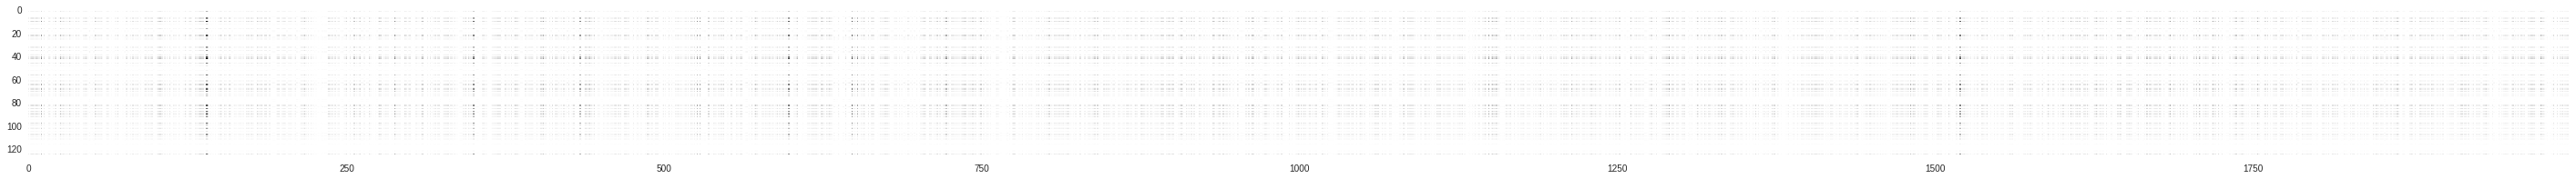

Combined X Shape: (2000, 128, 1)
Combined Y Shape: (2000, 2)
Y Example (should be 1s & 0s): [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
X Range: -0.43102083:19.501577
Input Shape: (128, 1)
('x_train shape:', (1200, 128, 1))
(1200, 'train samples')
(400, 'test samples')
(400, 'validation samples')
Class Weights: [0.62565172 2.48962656]


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

featsA = feats

X= encoded_data 

print('Normalizing X')
X = (X - np.mean(X)) / np.std(X)

fig = plt.figure(figsize=(50,3))
plt.imshow(np.transpose(X),aspect='auto')
Y = y_all
plt.show()
X = np.expand_dims(X,2)

# Split training test and validation data 
test_split = 0.2
val_split = 0.2
random_seed=1017
val_prop = val_split / (1-test_split)
featsA.x_train, featsA.x_test, featsA.y_train, featsA.y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
featsA.x_train, featsA.x_val, featsA.y_train, featsA.y_val = train_test_split(featsA.x_train, featsA.y_train, test_size=val_prop, random_state=random_seed)

# Compute model input shape
featsA.input_shape = X.shape[1:]

#compute class weights for uneven classes
y_ints = [y.argmax() for y in featsA.y_train]
class_weights = class_weight.compute_class_weight('balanced',
                                               np.unique(y_ints),
                                               y_ints)
#Print some outputs
print('Combined X Shape: ' + str(X.shape))
print('Combined Y Shape: ' + str(Y.shape))
print('Y Example (should be 1s & 0s): ' + str(Y[0:10]))
print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
print('Input Shape: ' + str(featsA.input_shape))
print('x_train shape:', featsA.x_train.shape)
print(featsA.x_train.shape[0], 'train samples')
print(featsA.x_test.shape[0], 'test samples')
print(featsA.x_val.shape[0], 'validation samples')
print('Class Weights: ' + str(featsA.class_weights))



In [0]:
model, encoder = CreateModel(featsA, 
                    model_type='NN')

TrainTestVal(model, featsA,
             batch_size=4,train_epochs=10,
             model_type='NN')

Creating NN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128

KeyboardInterrupt: ignored